In [110]:
using LinearAlgebra;
using StaticArrays;
using Makie
using CairoMakie
using Printf
using Markdown


In [111]:
"""
    H(k, M) -> Matrix{Complex{Float64}}
    Hamiltonian for the QWZ Model 
"""
@inline function H(k::Vector{Float64}, M::Float64)
    kx = k[1]; ky = k[2];
    Mz = M + cos(kx) + cos(ky);
    [Mz sin(kx)-im*sin(ky); sin(kx)+im*sin(ky) -Mz]
end

@inline function evals(k::Vector{Float64}, M::Float64)
    kx = k[1]; ky = k[2];
    eigvals(Hermitian([M-cos(kx)-cos(ky) sin(kx)-im*sin(ky); sin(kx)+im*sin(ky) -(M-cos(kx)-cos(ky))]))
end

@inline function eigensystem_QWZ(k::Vector{Float64}, M::Float64)
    kx = k[1]; ky = k[2];
    eigen(Hermitian([M-cos(kx)-cos(ky) sin(kx)-im*sin(ky); sin(kx)+im*sin(ky) -(M-cos(kx)-cos(ky))]))
end

"""
    plot_band_structure(M::Float64)
    Plot the band structure of the QWZ model
"""
function plot_bands3D_QWZ(;M::Float64, seedname::String = "QWZ_", title::String = "QWZ Model")
    # construction of the grid 
    npts_perdim = 300
    rng = LinRange(-pi, pi, npts_perdim)
    grid = Matrix{Vector{Float64}}(undef, npts_perdim, npts_perdim)
    for (n, kx) ∈ enumerate(rng)
        for (m, ky) ∈ enumerate(rng)
            grid[n, m] = [kx, ky]
        end
    end    


    E = evals.(grid, Ref(M))
    ek_1 = map(x -> x[1], E)
    ek_2 = map(x -> x[2], E)
    
    kxs = reshape(map(e->e[1], grid), (npts_perdim, npts_perdim))
    kys = reshape(map(e->e[2], grid), (npts_perdim, npts_perdim))

    f = Figure()
    ax = Axis3(f[1, 1], title = title * " , M = $M", elevation = pi / 40.0)


    Makie.surface!(ax, kxs, kys,  ek_1, colormap = :viridis)
    Makie.surface!(ax, kxs, kys, ek_2, colormap = :viridis)
    ax.xlabel = L"k_x"
    ax.ylabel = L"k_y"
    #Makie.save(assets_dir * seedname * "M=$M" * ".png", f)
    display(f)
end

plot_bands3D_QWZ

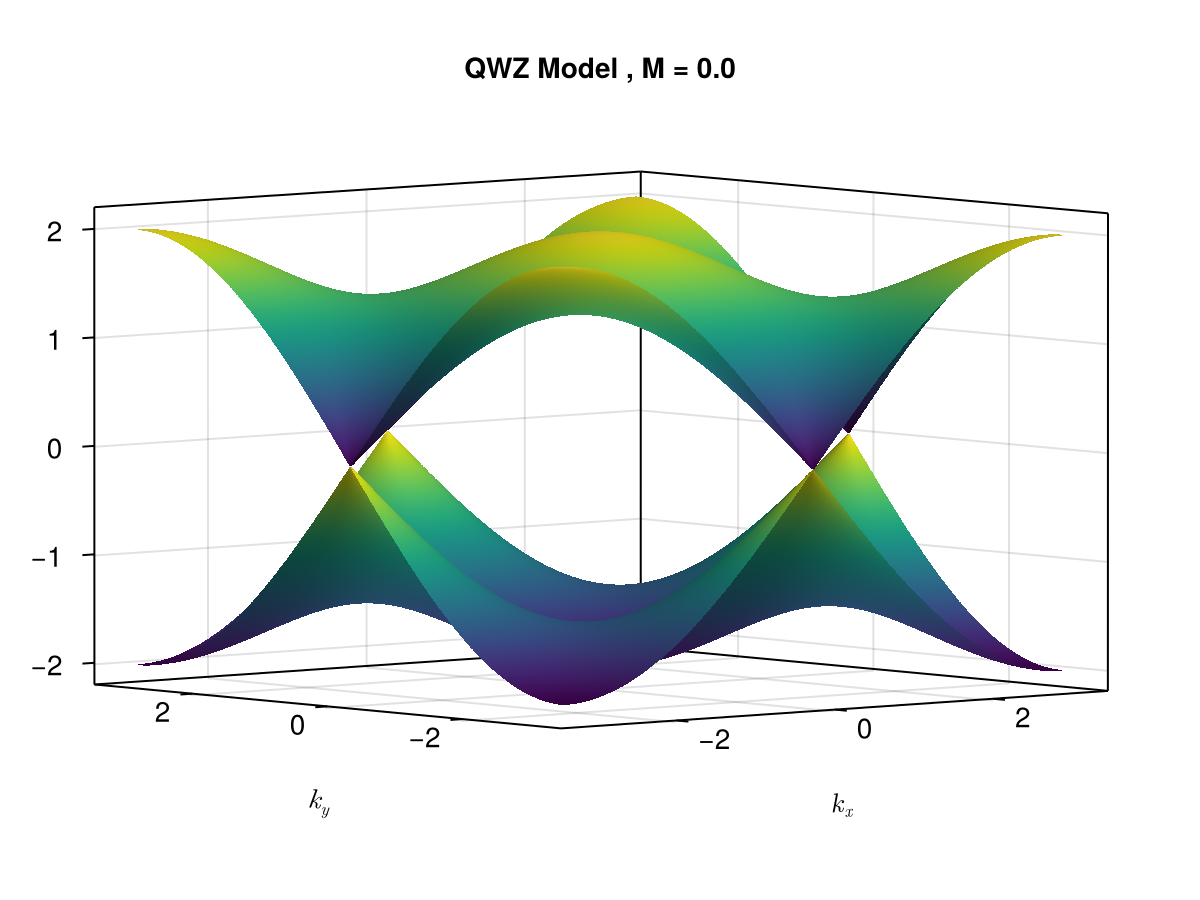

CairoMakie.Screen{IMAGE}


In [112]:
plot_bands3D_QWZ(M = 0.0)

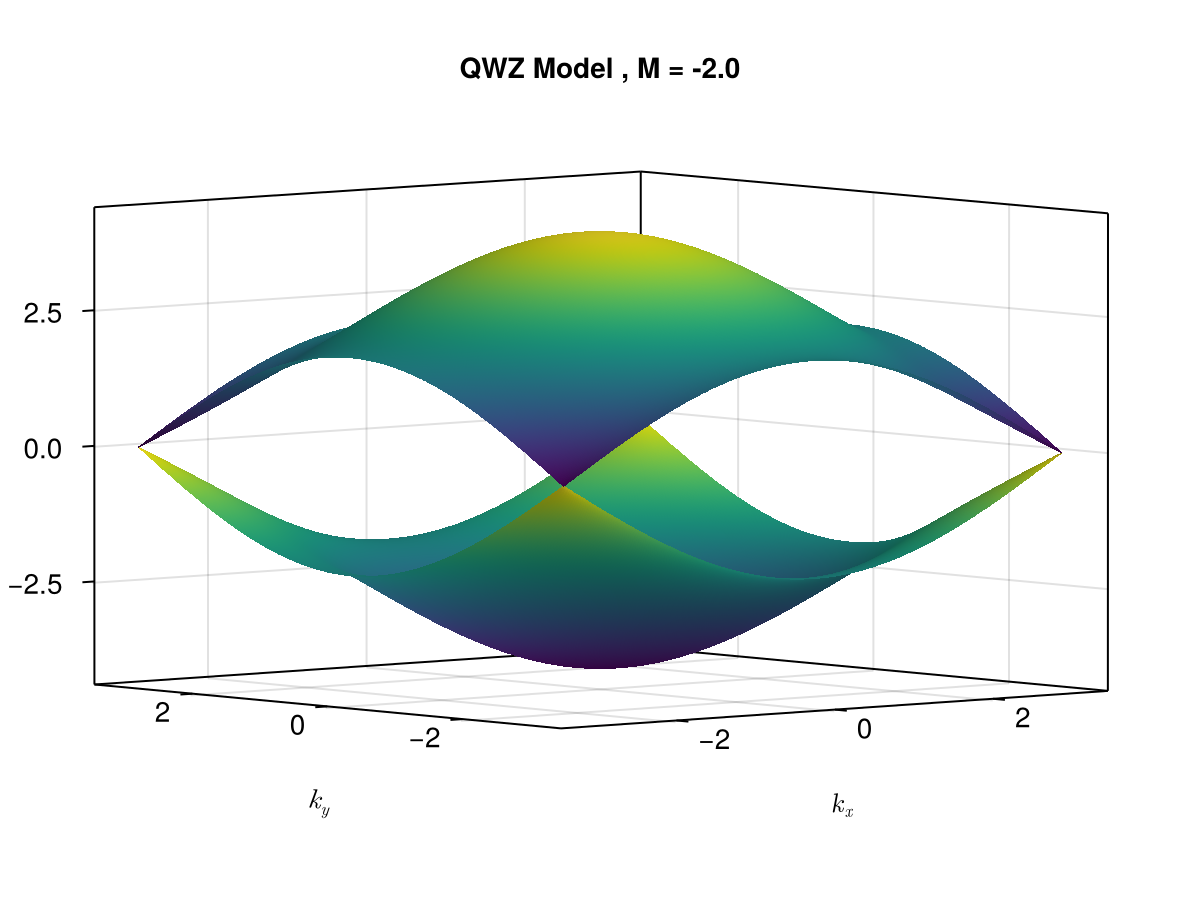

CairoMakie.Screen{IMAGE}


In [113]:
plot_bands3D_QWZ(M = -2.0)

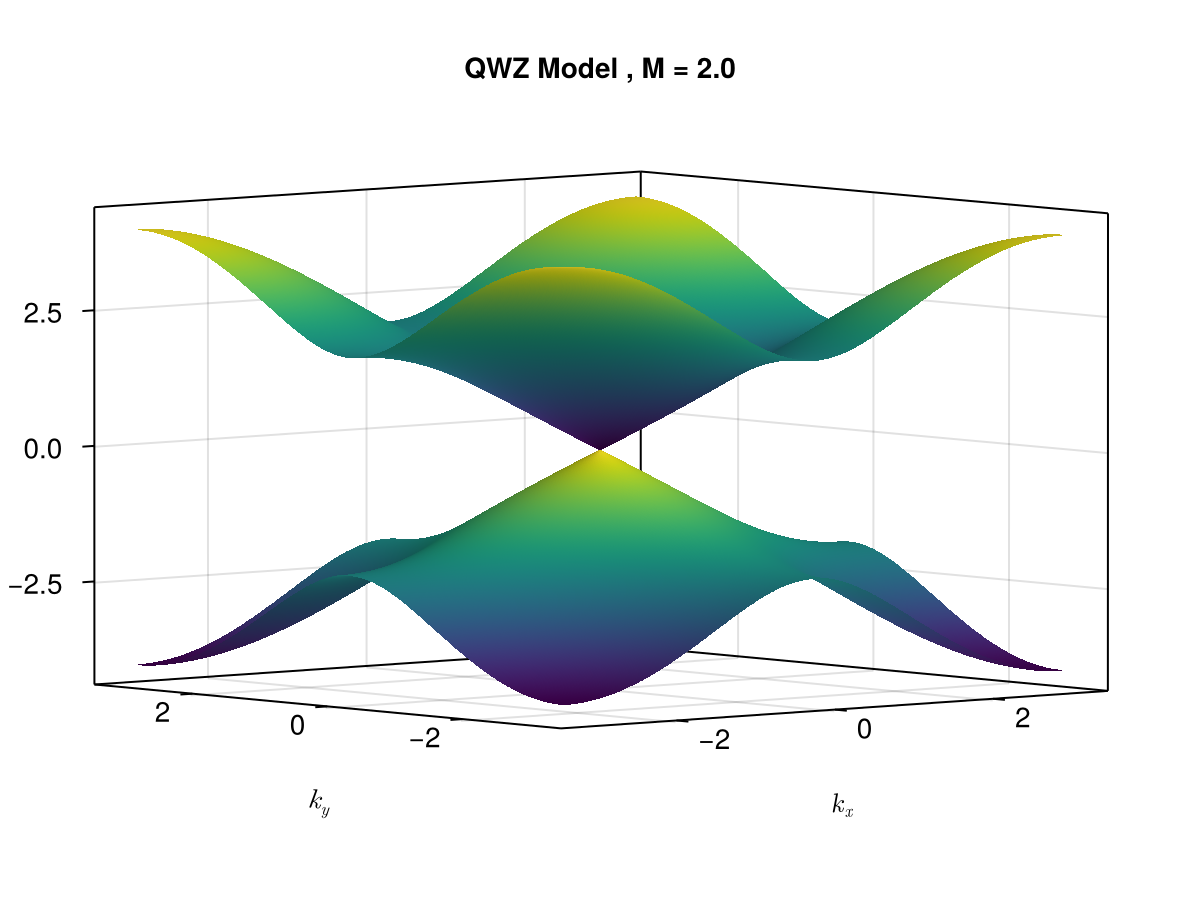

CairoMakie.Screen{IMAGE}


In [114]:
plot_bands3D_QWZ(M = 2.0)

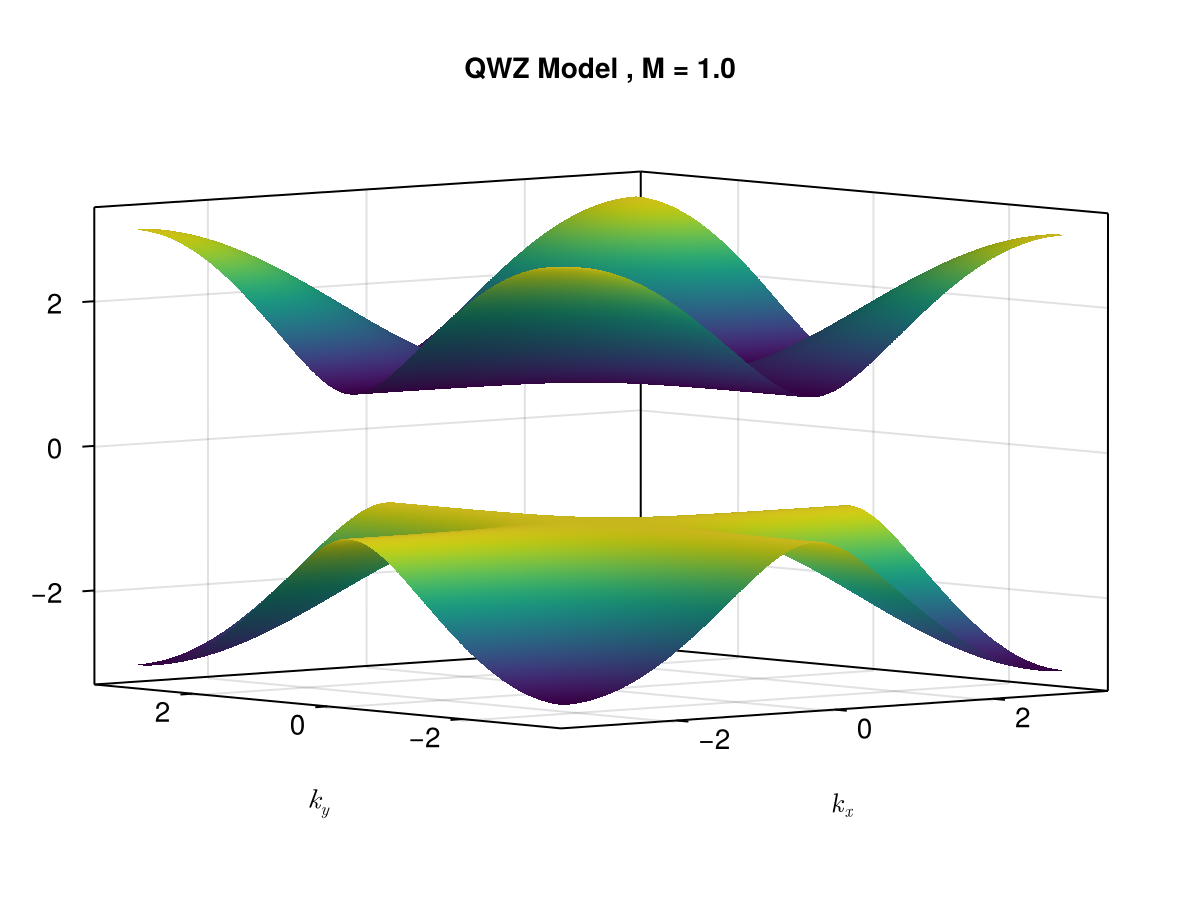

CairoMakie.Screen{IMAGE}


In [115]:
plot_bands3D_QWZ(M = 1.0)

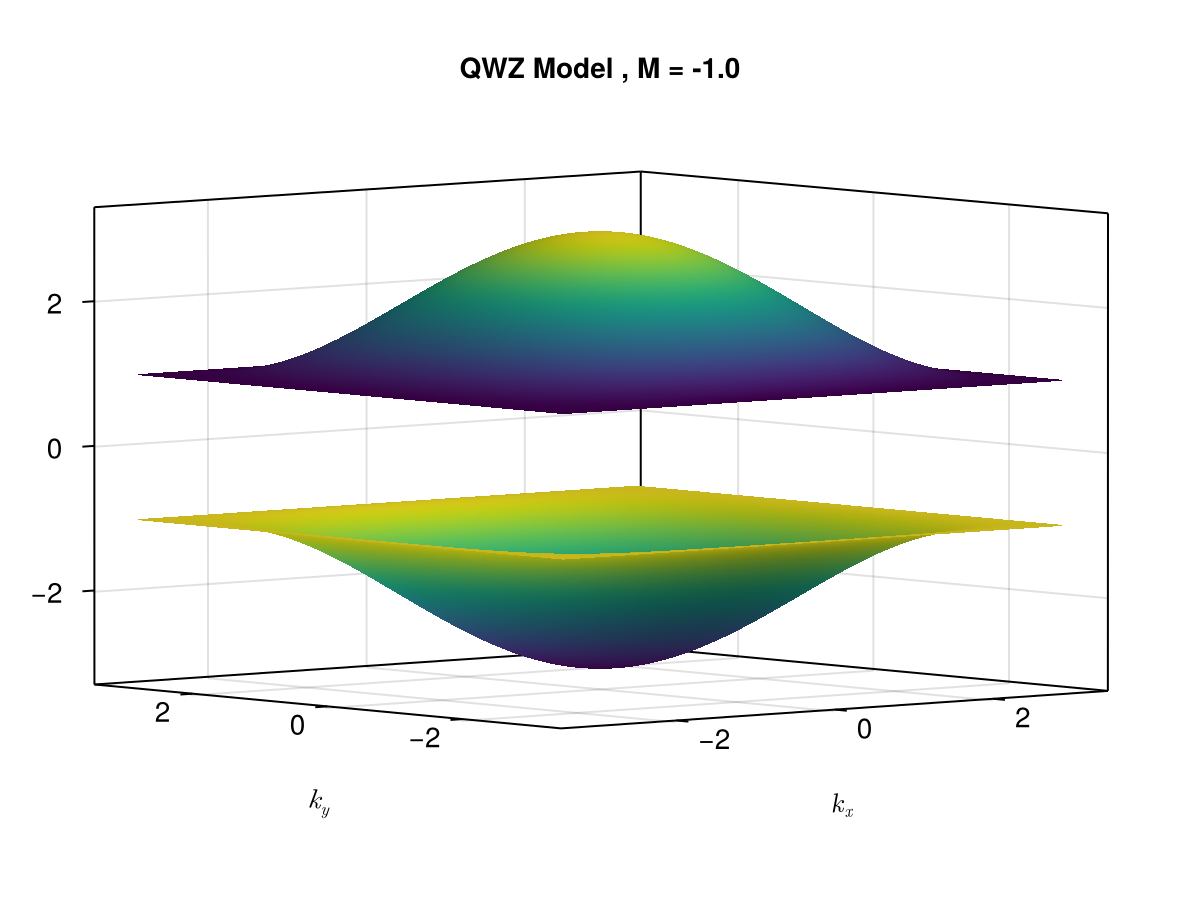

CairoMakie.Screen{IMAGE}


In [159]:
plot_bands3D_QWZ(M = -1.0)

## Wilson Loop Spectrum ## 

In [189]:
@inline function Wilson_Loop_fixed_ycycle(ps_ky::Vector{Vector{Float64}}, M::Float64, nps::Int = 1000)
    """
    This is similar to the Wilson loop computation in the SSH model, 
    I think it is possible to work out a connection between the two models (Dimensional reduction ?)
    """
    spectrum = eigensystem_QWZ.(ps_ky, Ref(M))

    # get eigenmodes 
    U_grid     = map(x -> x.vectors, spectrum)
    U_band     = map(x -> x[:, 1], U_grid)
    # so far, we have the eigenmodes of the band at all points of the momentum space grid
    res::Complex{Float64} = 1.0 + 0.0 * im
    for n ∈ 1 : nps
        res *= U_band[n]' * U_band[mod1(n + 1, nps)]
    end
    angle(res)
end


@inline function Berry_Phase_Along_xcycle(M::Float64, nps::Int = 1000)
    """
    Compute the Berry phase along the x cycle -- Goal is to calculate its monodromy
    """
    ps_kx = LinRange(-pi, pi, nps)
    phase_vals = Vector{Float64}(undef, nps)
    for (n, kx) ∈ enumerate(ps_kx)
        kps = Vector{Float64}[[kx, ky] for ky ∈ LinRange(-pi, pi, nps)]
        phase_vals[n] = Wilson_Loop_fixed_ycycle(kps, M, nps)
    end
    phase_vals
end

Berry_Phase_Along_xcycle (generic function with 2 methods)

In [190]:
function Winding(fvals)
    nvals = size(fvals, 1)
    res::Float64 = 0.0
    for n ∈ 1 : nvals - 1
        nnext = n + 1
        diff = fvals[nnext] - fvals[n]
        res += diff
    end
    res / 2π
end

Winding (generic function with 1 method)

In [191]:
function plot_topological_index_on_parameterspace(nps_wlcalc::Int = 100)
    # grid in parameter space 
    ps = range(-2.5, 2.5, length = 100)
    # compute the topological index for each point in the parameter space
    Cs = Vector{Float64}(undef, 100)
    for (n, M) ∈ enumerate(ps)
        Cs[n] = Winding(Berry_Phase_Along_xcycle(M, nps_wlcalc))
    end
    f = Figure()
    ax = Axis(f[1, 1], title="Chern number of the QWZ model over parameter space. ")
    ax.xlabel = L"M"
    ax.ylabel = "Chern Number"
    lines!(ax, ps, Cs, color = :blue, linewidth = 2)
    f
end

plot_topological_index_on_parameterspace (generic function with 2 methods)

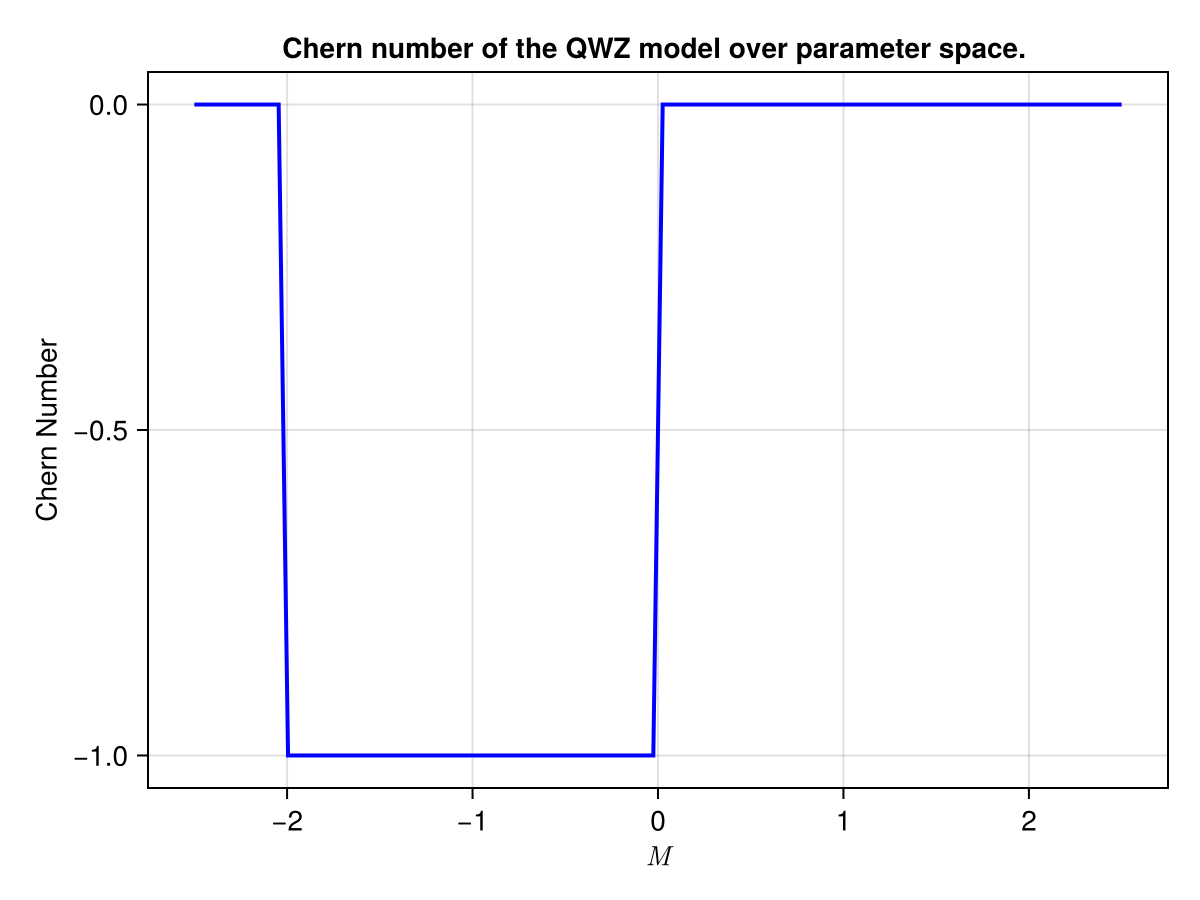

In [192]:
plot_topological_index_on_parameterspace(500)

In [193]:
# Plotting the Winding of the Berry phase along the x cycle for M = 1.0 
function plot_winding_berry_phase(;M::Float64, nps::Int = 100)
    ks = LinRange(-pi, pi, nps)
    bp = Berry_Phase_Along_xcycle(M, nps)
    f = Figure()
    ax = Axis(f[1, 1], title="Berry phase winding , M = $M")
    ax.xlabel = L"k_x"
    ax.ylabel = L"\Phi"
    lines!(ax, ks, bp, color = :blue, linewidth = 2)
    f
end


plot_winding_berry_phase (generic function with 1 method)

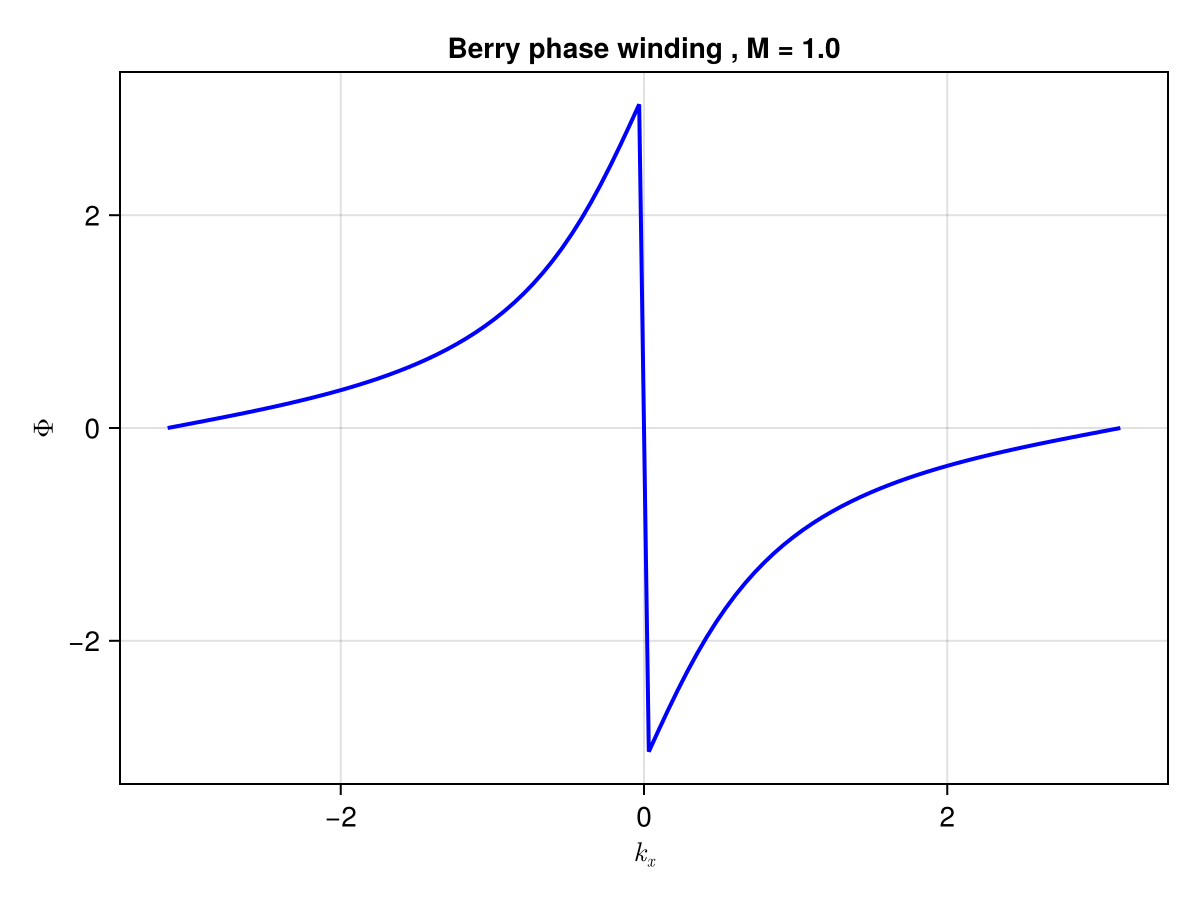

In [194]:
plot_winding_berry_phase(M = 1.0, nps = 100)

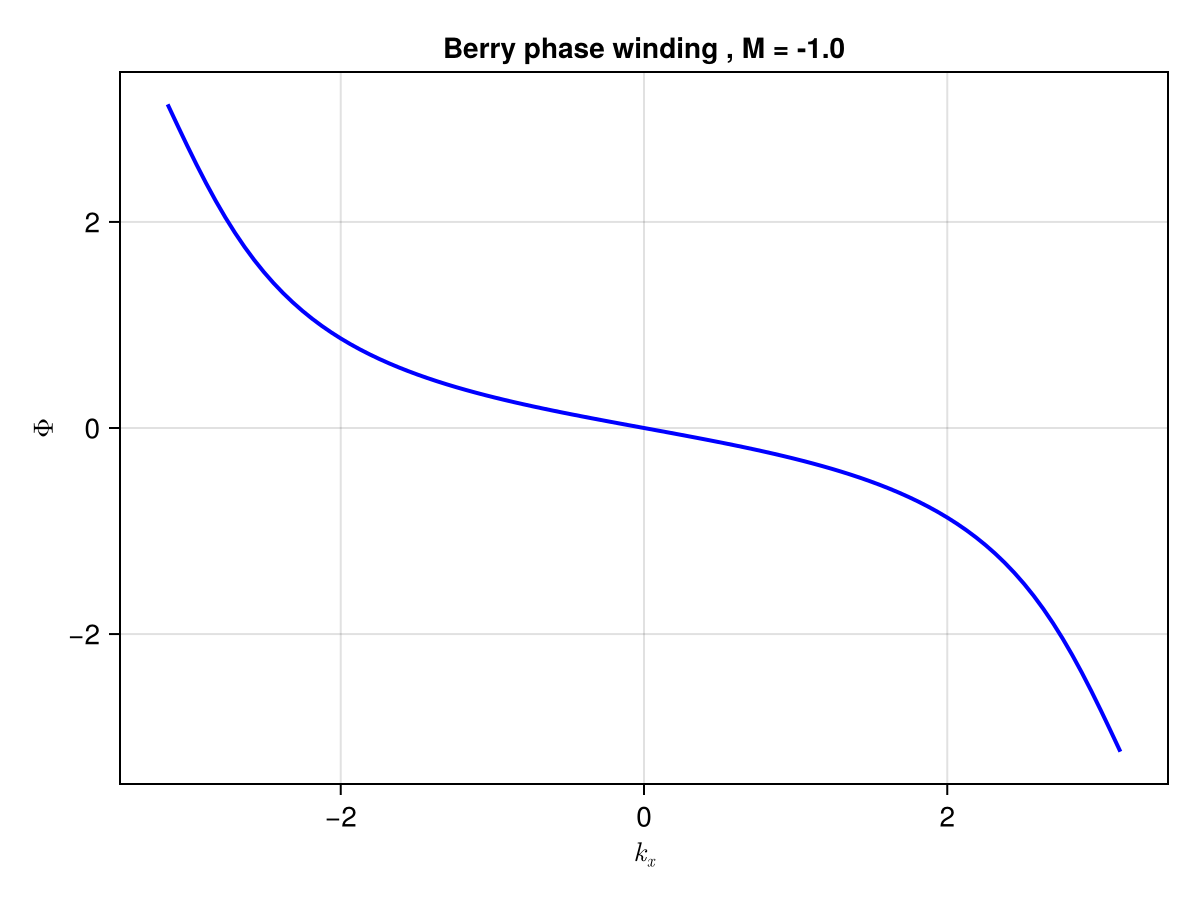

In [195]:
plot_winding_berry_phase(M = -1.0, nps = 100)

In [181]:
r = Berry_Phase_Along_xcycle(1.0, 200)
for n ∈ 1 : 200
    @printf("n = %d, bp = %f \n", n, r[n])
end

n = 1, bp = 0.000000 
n = 2, bp = 0.001361 
n = 3, bp = 0.002723 
n = 4, bp = 0.004086 
n = 5, bp = 0.005452 
n = 6, bp = 0.006822 
n = 7, bp = 0.008196 
n = 8, bp = 0.009574 
n = 9, bp = 0.010959 
n = 10, bp = 0.012351 
n = 11, bp = 0.013750 
n = 12, bp = 0.015159 
n = 13, bp = 0.016576 
n = 14, bp = 0.018005 
n = 15, bp = 0.019445 
n = 16, bp = 0.020897 
n = 17, bp = 0.022363 
n = 18, bp = 0.023844 
n = 19, bp = 0.025340 
n = 20, bp = 0.026852 
n = 21, bp = 0.028383 
n = 22, bp = 0.029932 
n = 23, bp = 0.031501 
n = 24, bp = 0.033092 
n = 25, bp = 0.034705 
n = 26, bp = 0.036342 
n = 27, bp = 0.038004 
n = 28, bp = 0.039692 
n = 29, bp = 0.041408 
n = 30, bp = 0.043154 
n = 31, bp = 0.044931 
n = 32, bp = 0.046740 
n = 33, bp = 0.048584 
n = 34, bp = 0.050463 
n = 35, bp = 0.052381 
n = 36, bp = 0.054337 
n = 37, bp = 0.056336 
n = 38, bp = 0.058378 
n = 39, bp = 0.060466 
n = 40, bp = 0.062603 
n = 41, bp = 0.064789 
n = 42, bp = 0.067029 
n = 43, bp = 0.069324 
n = 44, bp = 0.07167

In [187]:
function unwrap_phase(phases)
    unwrapped = phases[1]
    for i in 2:length(phases)
        delta = phases[i] - phases[i - 1]
        if delta > 0.5
            delta -= 1.0
        elseif delta < -0.5
            delta += 1.0
        end
        push!(unwrapped, unwrapped[end] + delta)
    end
    return unwrapped
end

unwrap_phase (generic function with 1 method)

In [188]:
r = Berry_Phase_Along_xcycle(1.0, 200)
u = unwrap_phase(r)

MethodError: MethodError: no method matching push!(::Float64, ::Float64)
The function `push!` exists, but no method is defined for this combination of argument types.

Closest candidates are:
  push!(::Any, ::Any, !Matched::Any)
   @ Base abstractarray.jl:3529
  push!(::Any, ::Any, !Matched::Any, !Matched::Any...)
   @ Base abstractarray.jl:3530
  push!(!Matched::Vector{Any}, ::Any)
   @ Base array.jl:1267
  ...
